In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.utils.metrics as metrics
import src.model.train_rnn as train_recurrent
import src.model.ae as ae
import src.model.rnn as rnn
import src.utils.gau as gaussian
import src.probing.linear_probing as lp
import src.utils.plots as plots

/home/pascual/miniforge3/envs/inteli_cpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')

def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

In [3]:
train_template = torch.tensor(stamps_dataset['Train']['template'], dtype=torch.float32)
validation_template = torch.tensor(stamps_dataset['Validation']['template'], dtype=torch.float32)
test_template = torch.tensor(stamps_dataset['Test']['template'], dtype=torch.float32)

train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_image = torch.tensor(stamps_dataset['Train']['images'], dtype=torch.float32)
validation_image = torch.tensor(stamps_dataset['Validation']['images'], dtype=torch.float32)
test_image = torch.tensor(stamps_dataset['Test']['images'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

train_template = train_template.unsqueeze(1).repeat(1, 5, 1, 1)
validation_template = validation_template.unsqueeze(1).repeat(1, 5, 1, 1)
test_template = test_template.unsqueeze(1).repeat(1, 5, 1, 1)


train_dataset = torch.stack((train_template, train_image, train_difference), dim=3  )
validation_dataset = torch.stack((validation_template, validation_difference, validation_difference), dim=3)
test_dataset = torch.stack((test_template, test_image, test_difference), dim=3)

train_template = train_template.unsqueeze(2)  # (samples, 5, 1, 21, 21)
train_image = train_image.unsqueeze(2)        
train_difference = train_difference.unsqueeze(2)  

validation_template = validation_template.unsqueeze(2)
validation_image = validation_image.unsqueeze(2)
validation_difference = validation_difference.unsqueeze(2)

test_template = test_template.unsqueeze(2)
test_image = test_image.unsqueeze(2)
test_difference = test_difference.unsqueeze(2)

# Apilar los tensores a lo largo de la dimensión correcta
train_dataset = torch.cat((train_template, train_image, train_difference), dim=2)
validation_dataset = torch.cat((validation_template, validation_image, validation_difference), dim=2)
test_dataset = torch.cat((test_template, test_image, test_difference), dim=2)

# Crear los conjuntos de datos
train_dataset = TensorDataset(train_dataset, train_class_0)
validation_dataset = TensorDataset(validation_dataset, validation_class_0)
test_dataset = TensorDataset(test_dataset, test_class_0)

train_dataset.tensors[1]
unique, counts = torch.unique(train_dataset.tensors[1], return_counts=True)
print(dict(zip(unique.numpy(), counts.numpy())))

from torch.utils.data import Subset

# Get the indices of each class
class_indices = {cls: (train_dataset.tensors[1] == cls).nonzero(as_tuple=True)[0] for cls in unique}

# Find the minimum number of samples in any class
min_samples = min(len(indices) for indices in class_indices.values())

# Create balanced indices by sampling min_samples from each class
balanced_indices = torch.cat([indices[:min_samples] for indices in class_indices.values()])

# Create a balanced dataset
balanced_train_dataset = Subset(train_dataset, balanced_indices)

# Verify the balance
balanced_counts = torch.unique(balanced_train_dataset.dataset.tensors[1][balanced_indices], return_counts=True)

{np.float32(0.0): np.int64(28092), np.float32(1.0): np.int64(1516), np.float32(2.0): np.int64(93619)}


In [4]:
model = ae.AE(50, 3, name="autoencoder final")
model.load_state_dict(torch.load('models/model_final.pth'))
model.eval()

/tmp/ipykernel_2985434/2931554739.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/model_final.pth'))


AE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2304, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=2304, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened

In [5]:
hidden_dim = 64
num_layers = 2
lr = 0.666e-3
batch_size = 1
use_gpu = False

# Experimentos Distintos Modelos

In [12]:
importlib.reload(rnn)
importlib.reload(train_recurrent)
importlib.reload(metrics)

batch_size = 10

rnn_unbalanced = rnn.RNN('RNN', 5, 50, hidden_dim, num_layers, 3, name = "RNN Unbalanced")

curves_1, time_1 = train_recurrent.train_model(model,
                                             rnn_unbalanced,
                                             train_dataset,
                                             validation_dataset,
                                             test_dataset, 
                                             max_epochs=100, 
                                             batch_size=batch_size,
                                             lr=lr, 
                                             early_stop=6,
                                             criterion=rnn.loss_function,
                                             use_gpu=use_gpu
                                             )

torch.save(rnn_unbalanced.state_dict(), 'models/rnn_unbalanced_model_final_nb.pth')

Starting training ...


Epoch 9/100 (Early Stop) -- Iteration 110907 - Batch 12322/12323 - Train loss: 0.60229343 - Val loss: 1.26565039
Tiempo total de entrenamiento: 2039.29 [s]



In [ ]:
importlib.reload(rnn)
importlib.reload(train_recurrent)
importlib.reload(metrics)

rnn_model_lstm = rnn.RNN('LSTM', 5, 50, hidden_dim, num_layers, 3, name = "LSTM")

curves_2, time_2 = train_recurrent.train_model(model,
                                             rnn_model_lstm,
                                             balanced_train_dataset,
                                             validation_dataset,
                                             test_dataset, 
                                             max_epochs=100, 
                                             batch_size=batch_size,
                                             lr=lr, 
                                             early_stop=6,
                                             criterion=rnn.loss_function,
                                             use_gpu=use_gpu
                                             )

torch.save(rnn_model_lstm.state_dict(), 'models/rnn_lstm_model_final_nb.pth')


In [ ]:
importlib.reload(rnn)
importlib.reload(train_recurrent)
importlib.reload(metrics)

rnn_model_gru = rnn.RNN('GRU', 5, 50, hidden_dim, num_layers, 3, name = "GRU")

curves_3, time_3 = train_recurrent.train_model(model,
                                                rnn_model_gru,
                                                balanced_train_dataset,
                                                validation_dataset,
                                                test_dataset, 
                                                max_epochs=100, 
                                                batch_size=batch_size,
                                                lr=lr, 
                                                early_stop=6,
                                                criterion=rnn.loss_function,
                                                use_gpu=use_gpu
                                                )

torch.save(rnn_model_gru.state_dict(), 'models/rnn_gru_model_final_nb.pth')

# Augmentation

In [55]:
batch_size = 20

## Class Weights

In [ ]:
importlib.reload(rnn)
importlib.reload(train_recurrent)
importlib.reload(metrics)

class_counts = torch.bincount(train_dataset.tensors[1].long())
class_weights = 1. / class_counts.float()
weights = class_weights[train_dataset.tensors[1].long()]

rnn_model_cw = rnn.RNN('LSTM', 5, 50, hidden_dim, num_layers, 3, name = "LSTM with ClassWeights")

curves_4, time_4 = train_recurrent.train_model(model,
                                                rnn_model_cw,
                                                train_dataset,
                                                validation_dataset,
                                                test_dataset, 
                                                max_epochs=100, 
                                                batch_size=batch_size,
                                                lr=lr, 
                                                early_stop=6,
                                                weights=weights,
                                                criterion=rnn.loss_function,
                                                use_gpu=use_gpu
                                                )

torch.save(rnn_model_cw.state_dict(), 'models/rnn_cw_model_final_nb.pth')

## Weighted Random Sampler

In [ ]:
importlib.reload(rnn)
importlib.reload(train_recurrent)
importlib.reload(metrics)

rnn_model_rs = rnn.RNN('LSTM', 5, 50, hidden_dim, num_layers, 3, name = "LSTM with ClassWeights")

curves_5, time_5 = train_recurrent.train_model(model,
                                                rnn_model_rs,
                                                train_dataset,
                                                validation_dataset,
                                                test_dataset, 
                                                max_epochs=100, 
                                                batch_size=batch_size,
                                                lr=lr, 
                                                early_stop=6,
                                                weights=False,
                                                random_sampler = True,
                                                criterion=rnn.loss_function,
                                                use_gpu=use_gpu
                                                )

torch.save(rnn_model_rs.state_dict(), 'models/rnn_rs_model_final_nb.pth')

# Results

In [6]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

latent_test = model.time_sequence(test_dataset.tensors[0])
real_class = test_dataset.tensors[1]

## Unbalanced

/tmp/ipykernel_2985434/3539318247.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_unbalanced.load_state_dict(torch.load('models/rnn_unbalanced_model_final_nb.pth'))


Model: RNN 
Precision: 0.56402 
Recall: 0.46333 
F1: 0.4398



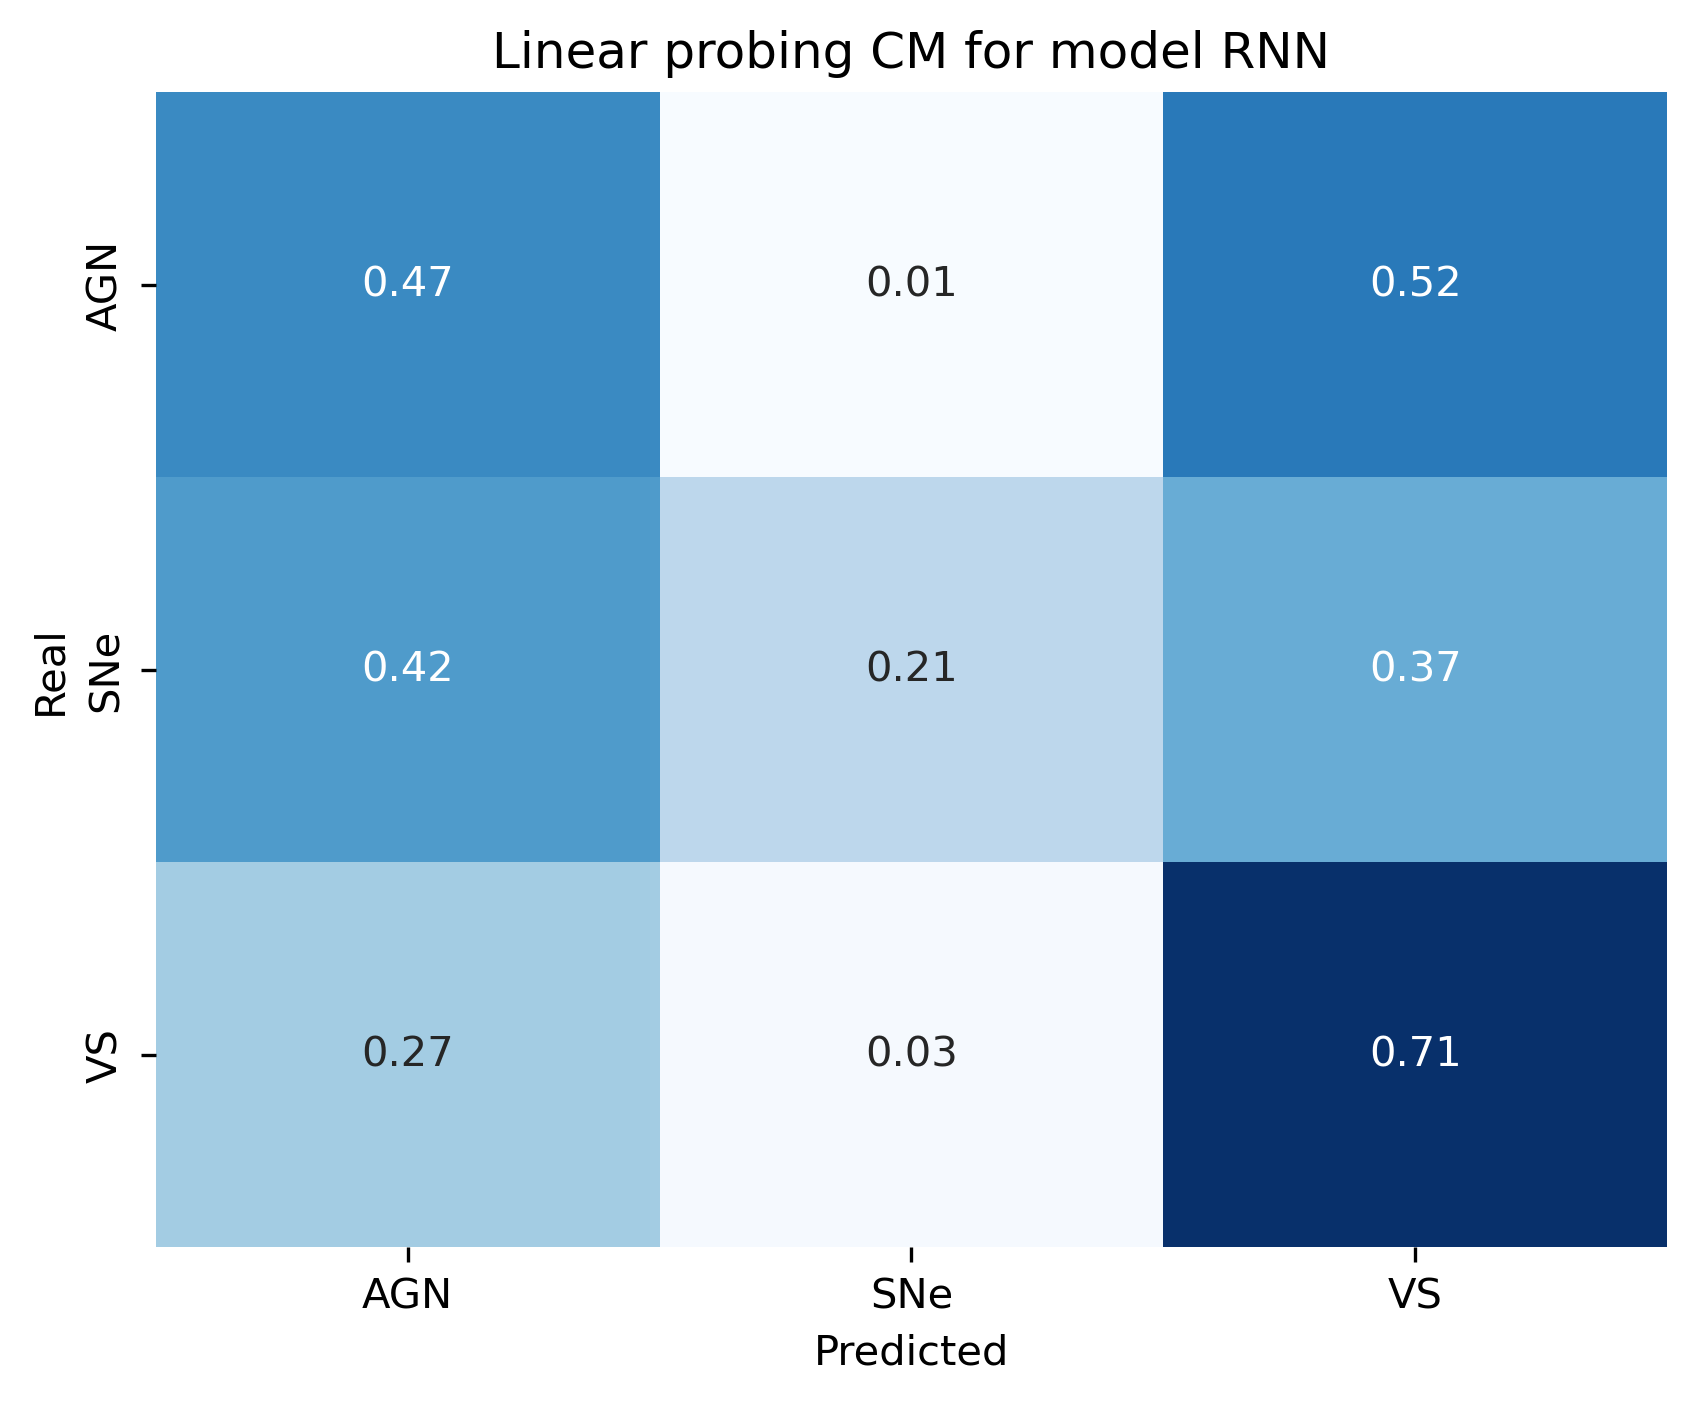

In [7]:
#RNN
importlib.reload(metrics)
rnn_unbalanced = rnn.RNN('RNN', 5, 50, hidden_dim, num_layers, 3, name = "RNN")
rnn_unbalanced.load_state_dict(torch.load('models/rnn_unbalanced_model_final_nb.pth'))

predicted = torch.argmax(F.softmax(rnn_unbalanced(latent_test), dim=1), dim=1)

precision, recall, f1 = metrics.performance_metrics(real_class, predicted)
cm = confusion_matrix(real_class, predicted, normalize='true')

print(f"Model: RNN",
      f"\nPrecision: {precision}",
      f"\nRecall: {recall}",
      f"\nF1: {f1}\n")

fig1 = metrics.plot_matrix([rnn_unbalanced], [cm])
fig1.savefig('figures/cm_rnn_unbalanced.png')

## RNN, LTSM, GRU

/tmp/ipykernel_2924505/2543763291.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model_rnn.load_state_dict(torch.load('models/rnn_rnn_model_final.pth'))


Model: RNN 
Precision: 0.64183 
Recall: 0.64333 
F1: 0.63924



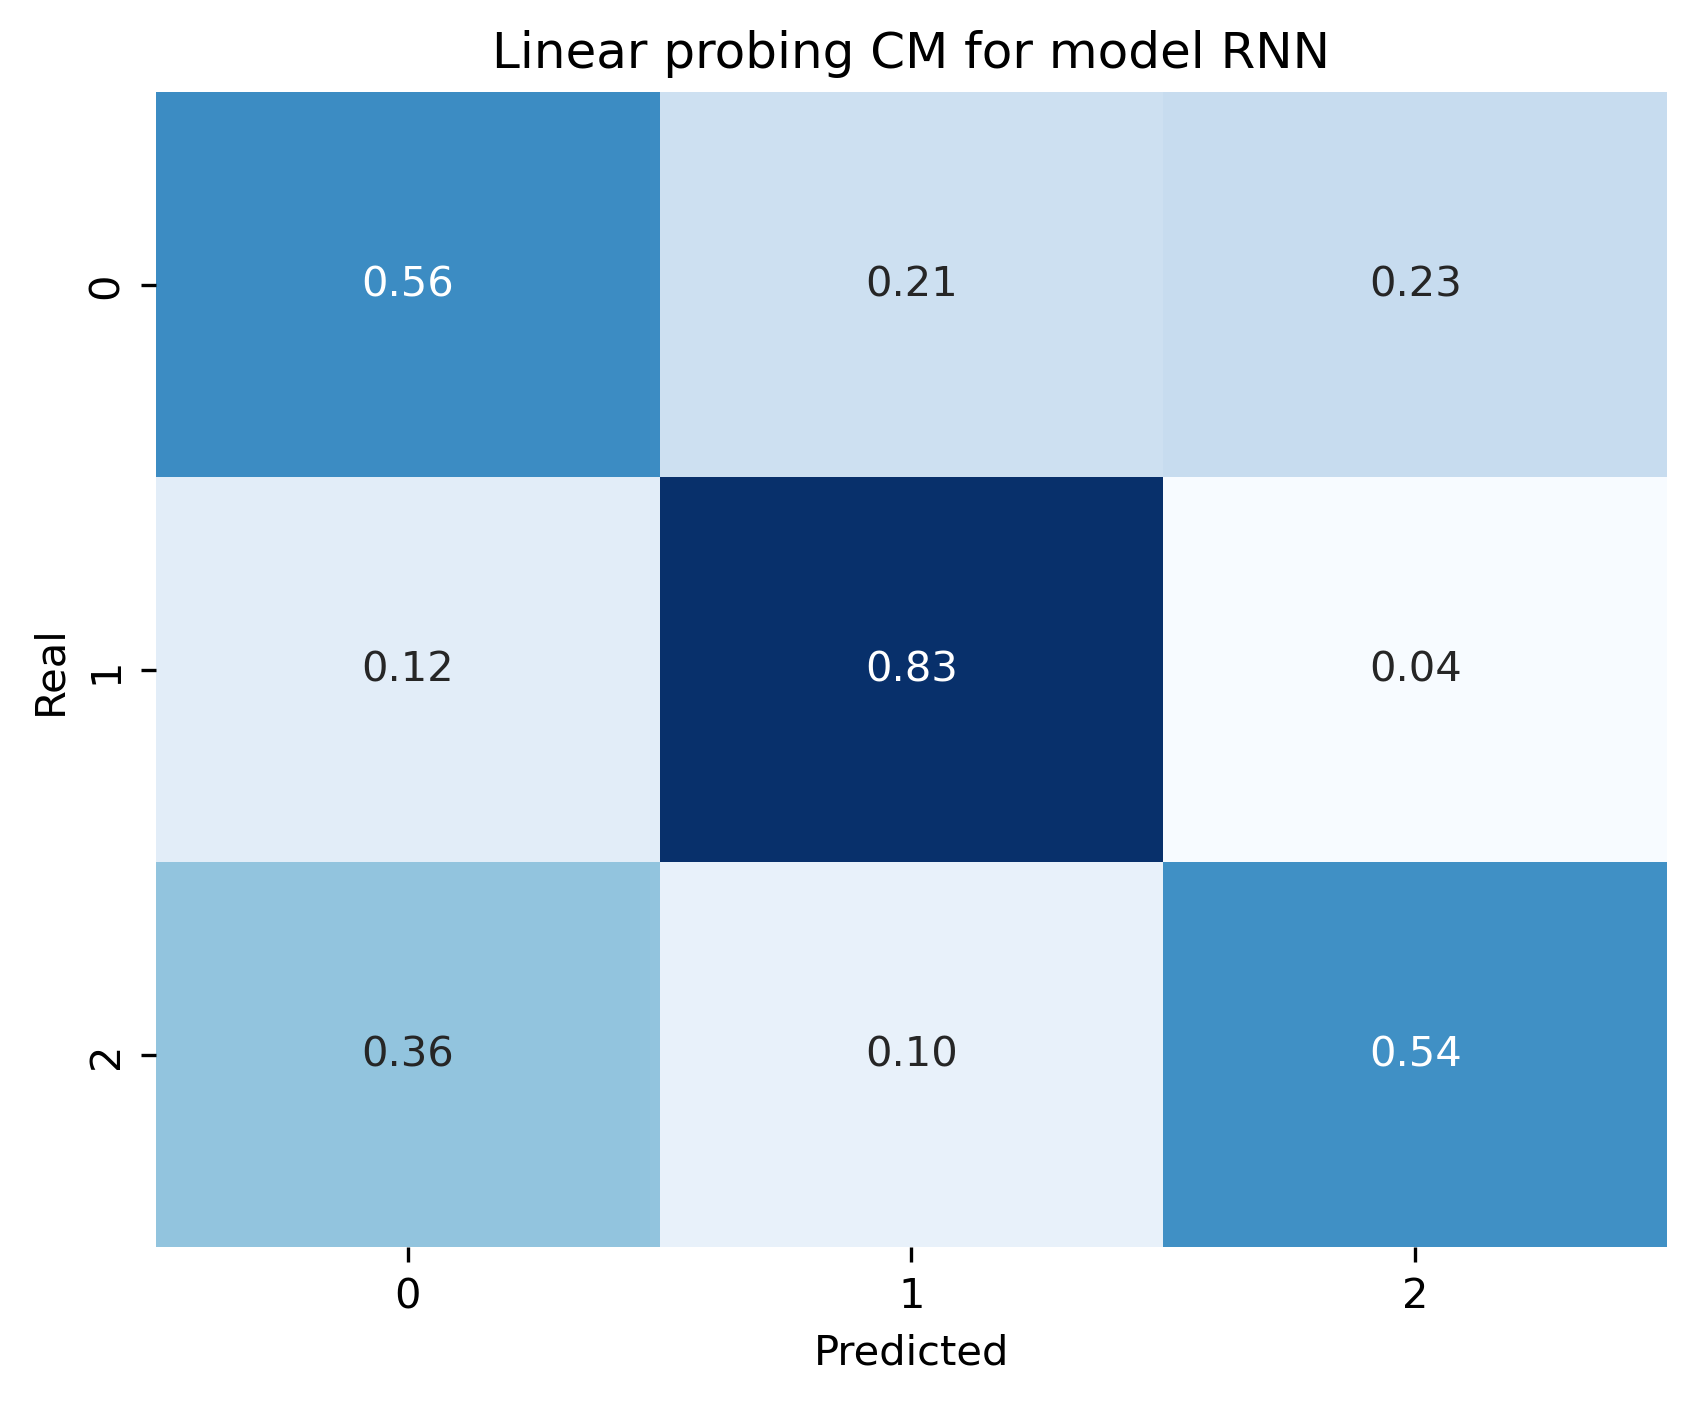

In [26]:
#RNN
rnn_model_rnn = rnn.RNN('RNN', 5, 50, hidden_dim, num_layers, 3, name = "RNN")
rnn_model_rnn.load_state_dict(torch.load('models/rnn_rnn_model_final.pth'))

predicted = torch.argmax(F.softmax(rnn_model_rnn(latent_test), dim=1), dim=1)

precision, recall, f1 = metrics.performance_metrics(real_class, predicted)
cm = confusion_matrix(real_class, predicted, normalize='true')

print(f"Model: RNN",
      f"\nPrecision: {precision}",
      f"\nRecall: {recall}",
      f"\nF1: {f1}\n")

fig1 = metrics.plot_matrix([rnn_model_rnn], [cm])
fig1.savefig('figures/cm_rnn.png')

/tmp/ipykernel_2924505/2738853907.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model_lstm.load_state_dict(torch.load('models/rnn_lstm_model_final.pth'))


Model: LSTM 
Precision: 0.63523 
Recall: 0.63833 
F1: 0.63393



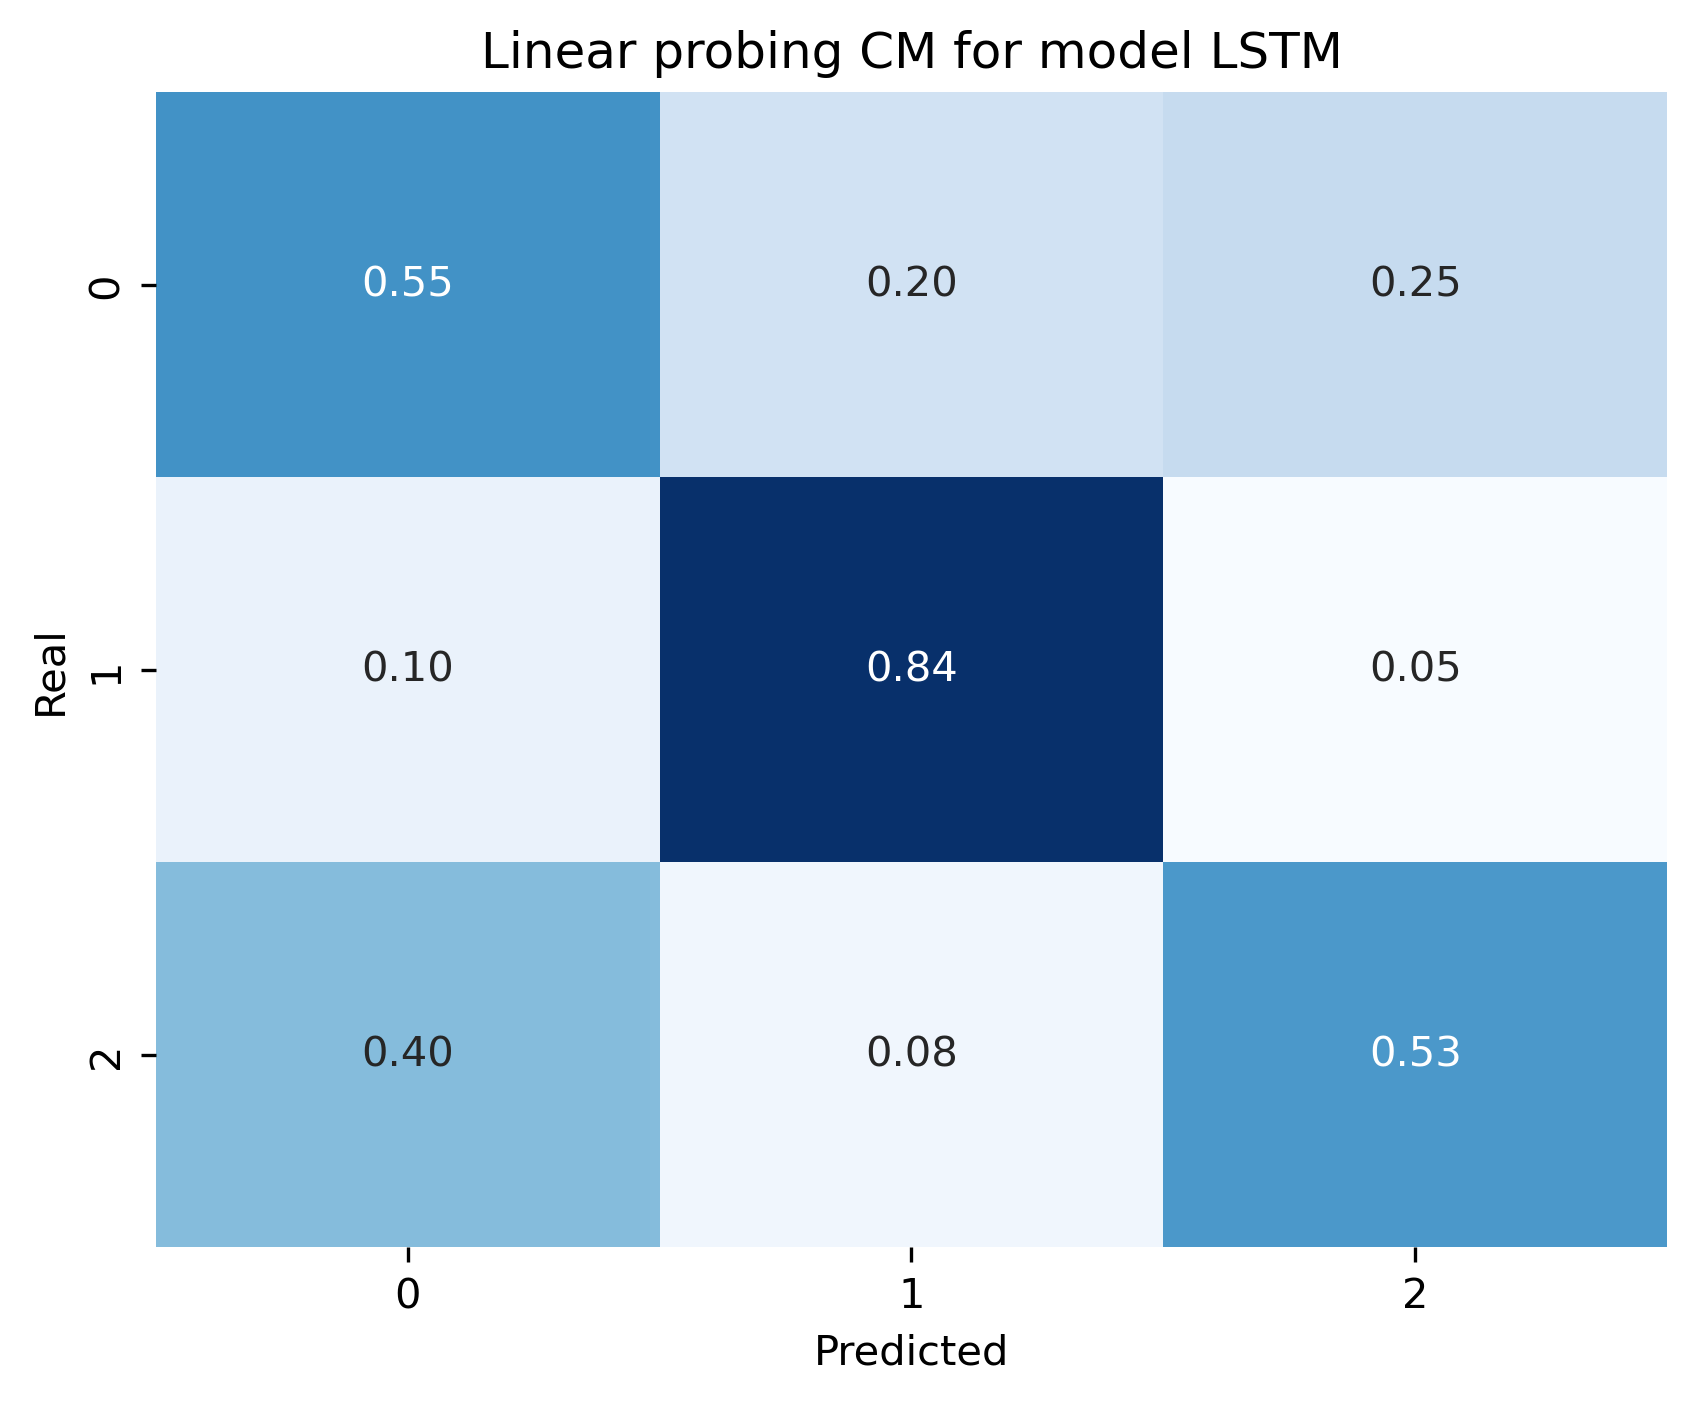

In [27]:
#LTSM
rnn_model_lstm = rnn.RNN('LSTM', 5, 50, hidden_dim, num_layers, 3, name = "LSTM")
rnn_model_lstm.load_state_dict(torch.load('models/rnn_lstm_model_final.pth'))

predicted = torch.argmax(F.softmax(rnn_model_lstm(latent_test), dim=1), dim=1)

precision, recall, f1 = metrics.performance_metrics(real_class, predicted)
cm = confusion_matrix(real_class, predicted, normalize='true')

print(f"Model: LSTM",
      f"\nPrecision: {precision}",
      f"\nRecall: {recall}",
      f"\nF1: {f1}\n")

fig2 = metrics.plot_matrix([rnn_model_lstm], [cm])
fig2.savefig('figures/cm_lstm_nb.png')

/tmp/ipykernel_2924505/641391649.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model_gru.load_state_dict(torch.load('models/rnn_gru_model_final.pth'))


Model: GRU 
Precision: 0.62519 
Recall: 0.62167 
F1: 0.60816



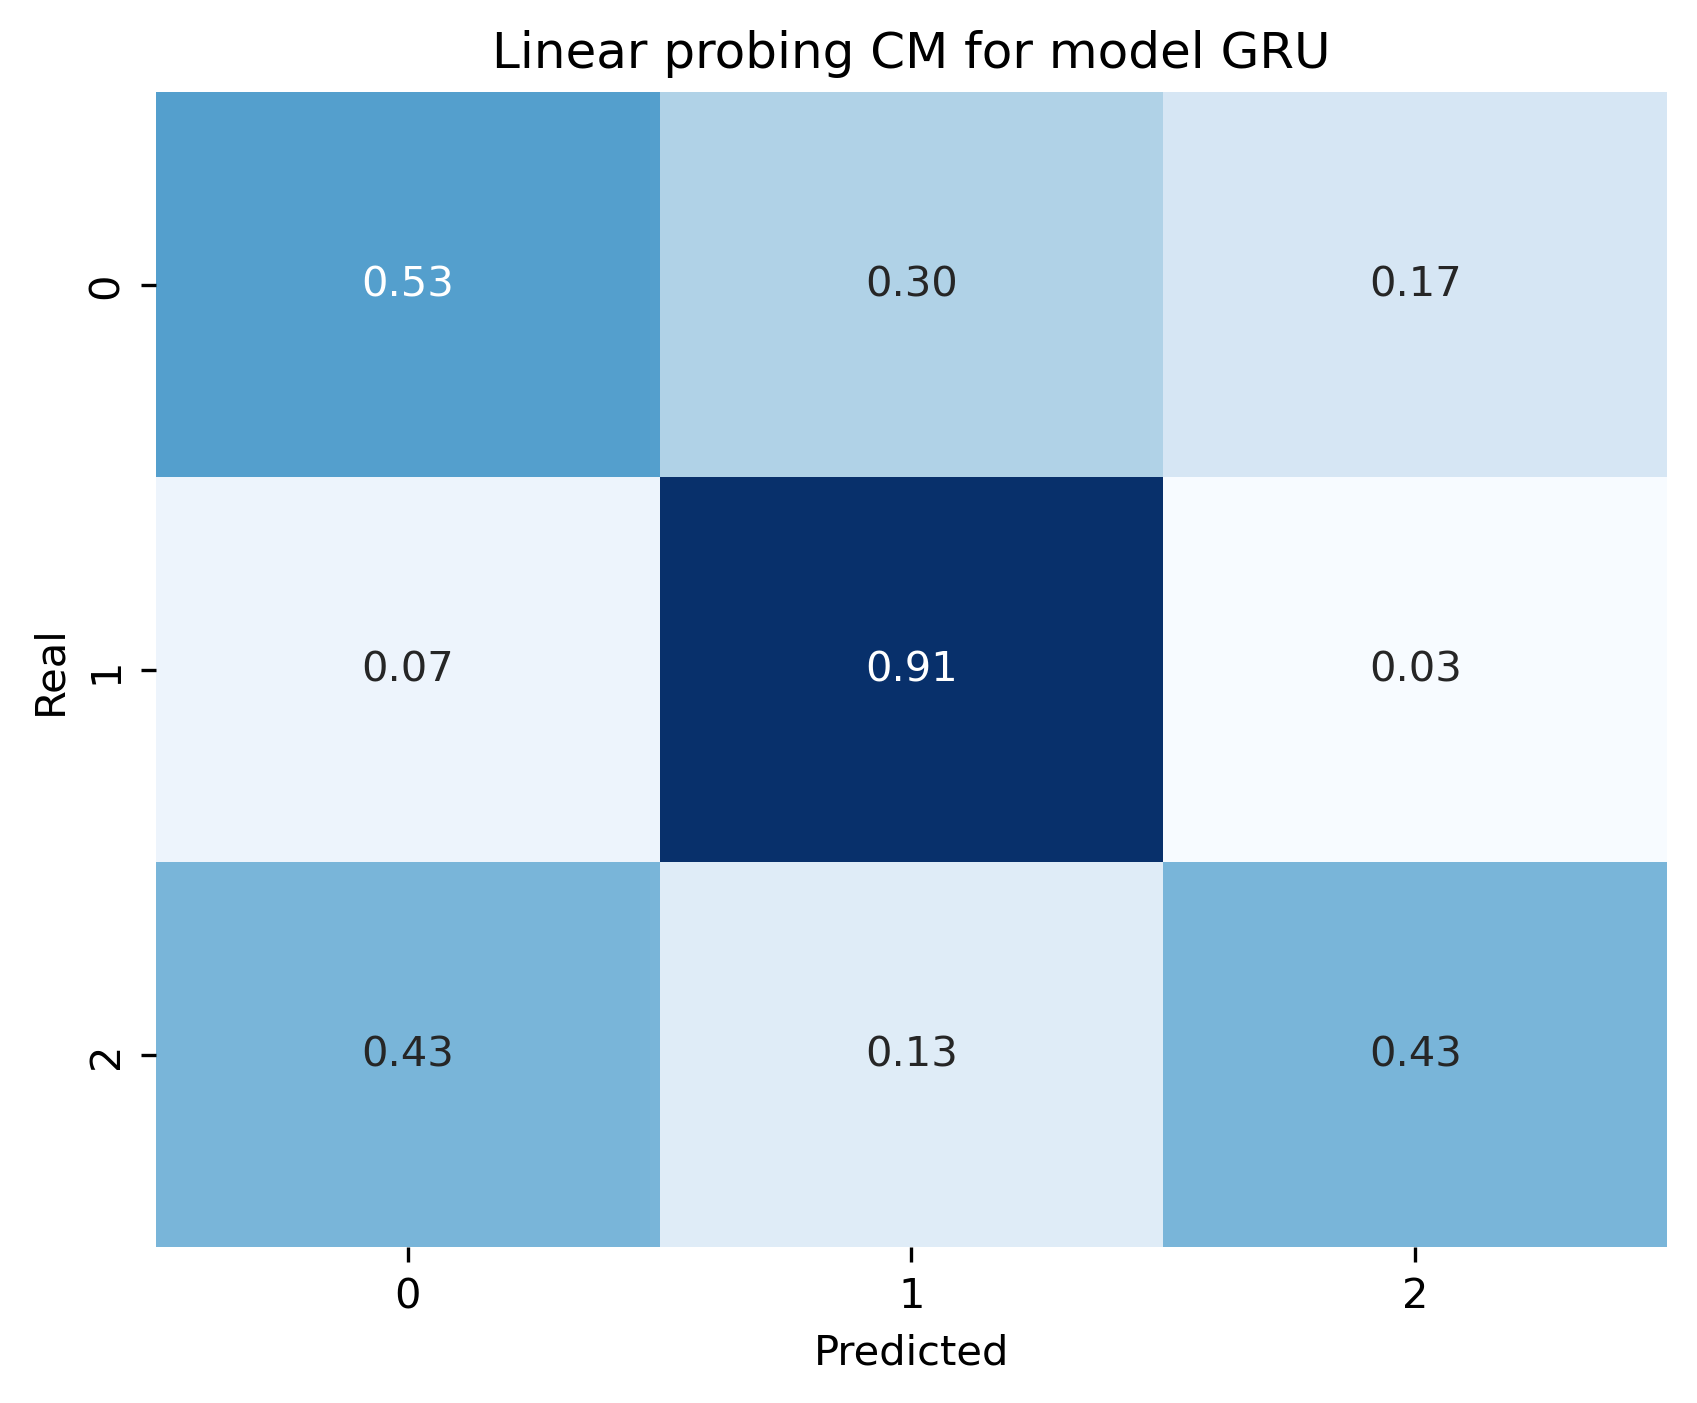

In [28]:
#GRU
rnn_model_gru = rnn.RNN('GRU', 5, 50, hidden_dim, num_layers, 3, name = "GRU")
rnn_model_gru.load_state_dict(torch.load('models/rnn_gru_model_final.pth'))

predicted = torch.argmax(F.softmax(rnn_model_gru(latent_test), dim=1), dim=1)

precision, recall, f1 = metrics.performance_metrics(real_class, predicted)
cm = confusion_matrix(real_class, predicted, normalize='true')

print(f"Model: GRU",
      f"\nPrecision: {precision}",
      f"\nRecall: {recall}",
      f"\nF1: {f1}\n")

fig3 = metrics.plot_matrix([rnn_model_gru], [cm])
fig3.savefig('figures/cm_gru_nb.png')

## Augmentations

/tmp/ipykernel_2924505/1331377243.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model_cw.load_state_dict(torch.load('models/rnn_cw_model_final.pth'))


Model: Weight Class 
Precision: 0.59968 
Recall: 0.52167 
F1: 0.50905



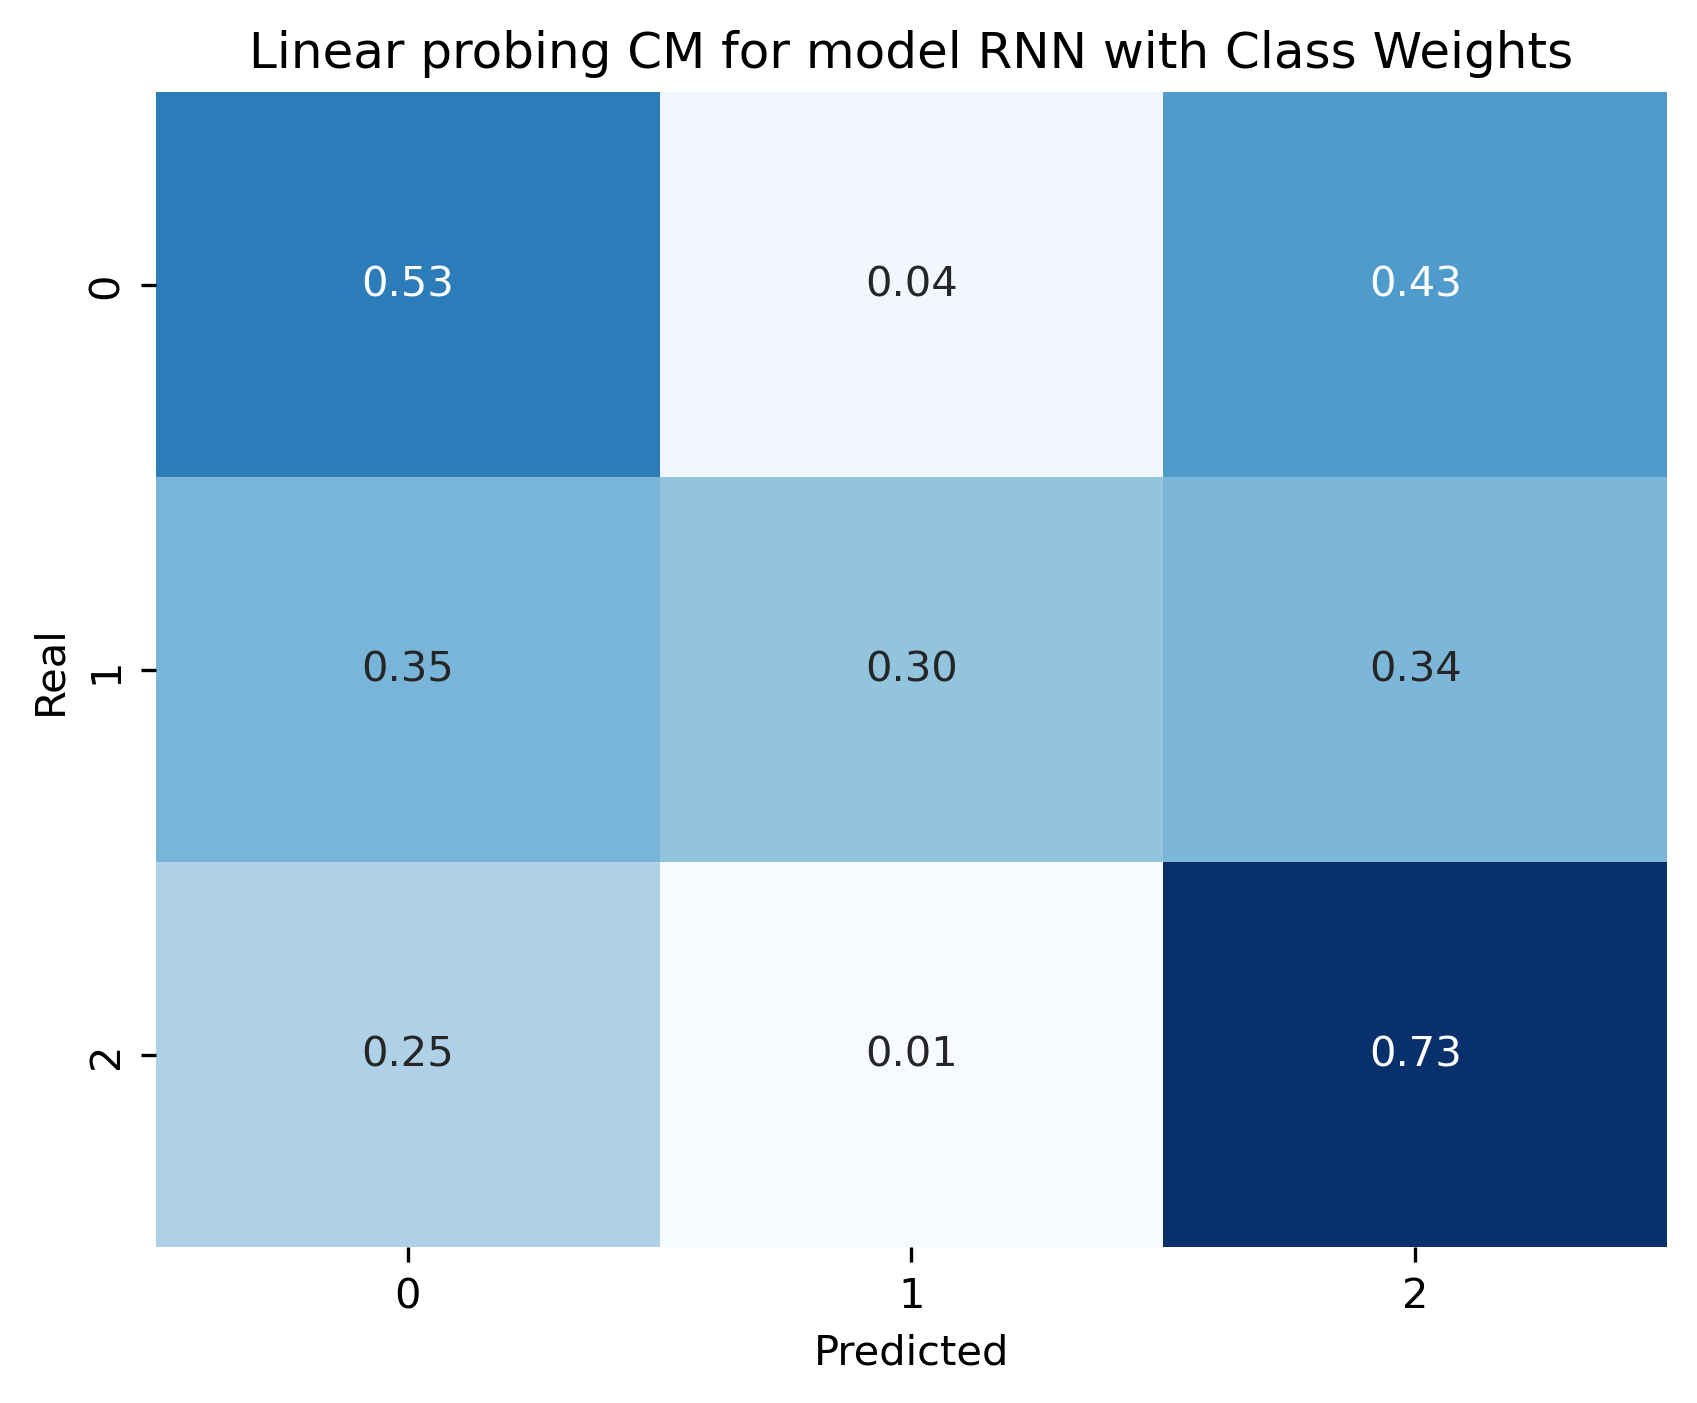

In [29]:
#Weight Class
rnn_model_cw = rnn.RNN('RNN', 5, 50, hidden_dim, num_layers, 3, name = "RNN with Class Weights")
rnn_model_cw.load_state_dict(torch.load('models/rnn_cw_model_final.pth'))

predicted = torch.argmax(F.softmax(rnn_model_cw(latent_test), dim=1), dim=1)

precision, recall, f1 = metrics.performance_metrics(real_class, predicted)
cm = confusion_matrix(real_class, predicted, normalize='true')

print(f"Model: Weight Class",
      f"\nPrecision: {precision}",
      f"\nRecall: {recall}",
      f"\nF1: {f1}\n")

fig4 = metrics.plot_matrix([rnn_model_cw], [cm])
fig4.savefig('figures/cm_cw_nb.png')

/tmp/ipykernel_2924505/598375740.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model_rs.load_state_dict(torch.load('models/rnn_rs_model_final.pth'))


Model: Random Sampler 
Precision: 0.63002 
Recall: 0.605 
F1: 0.61166



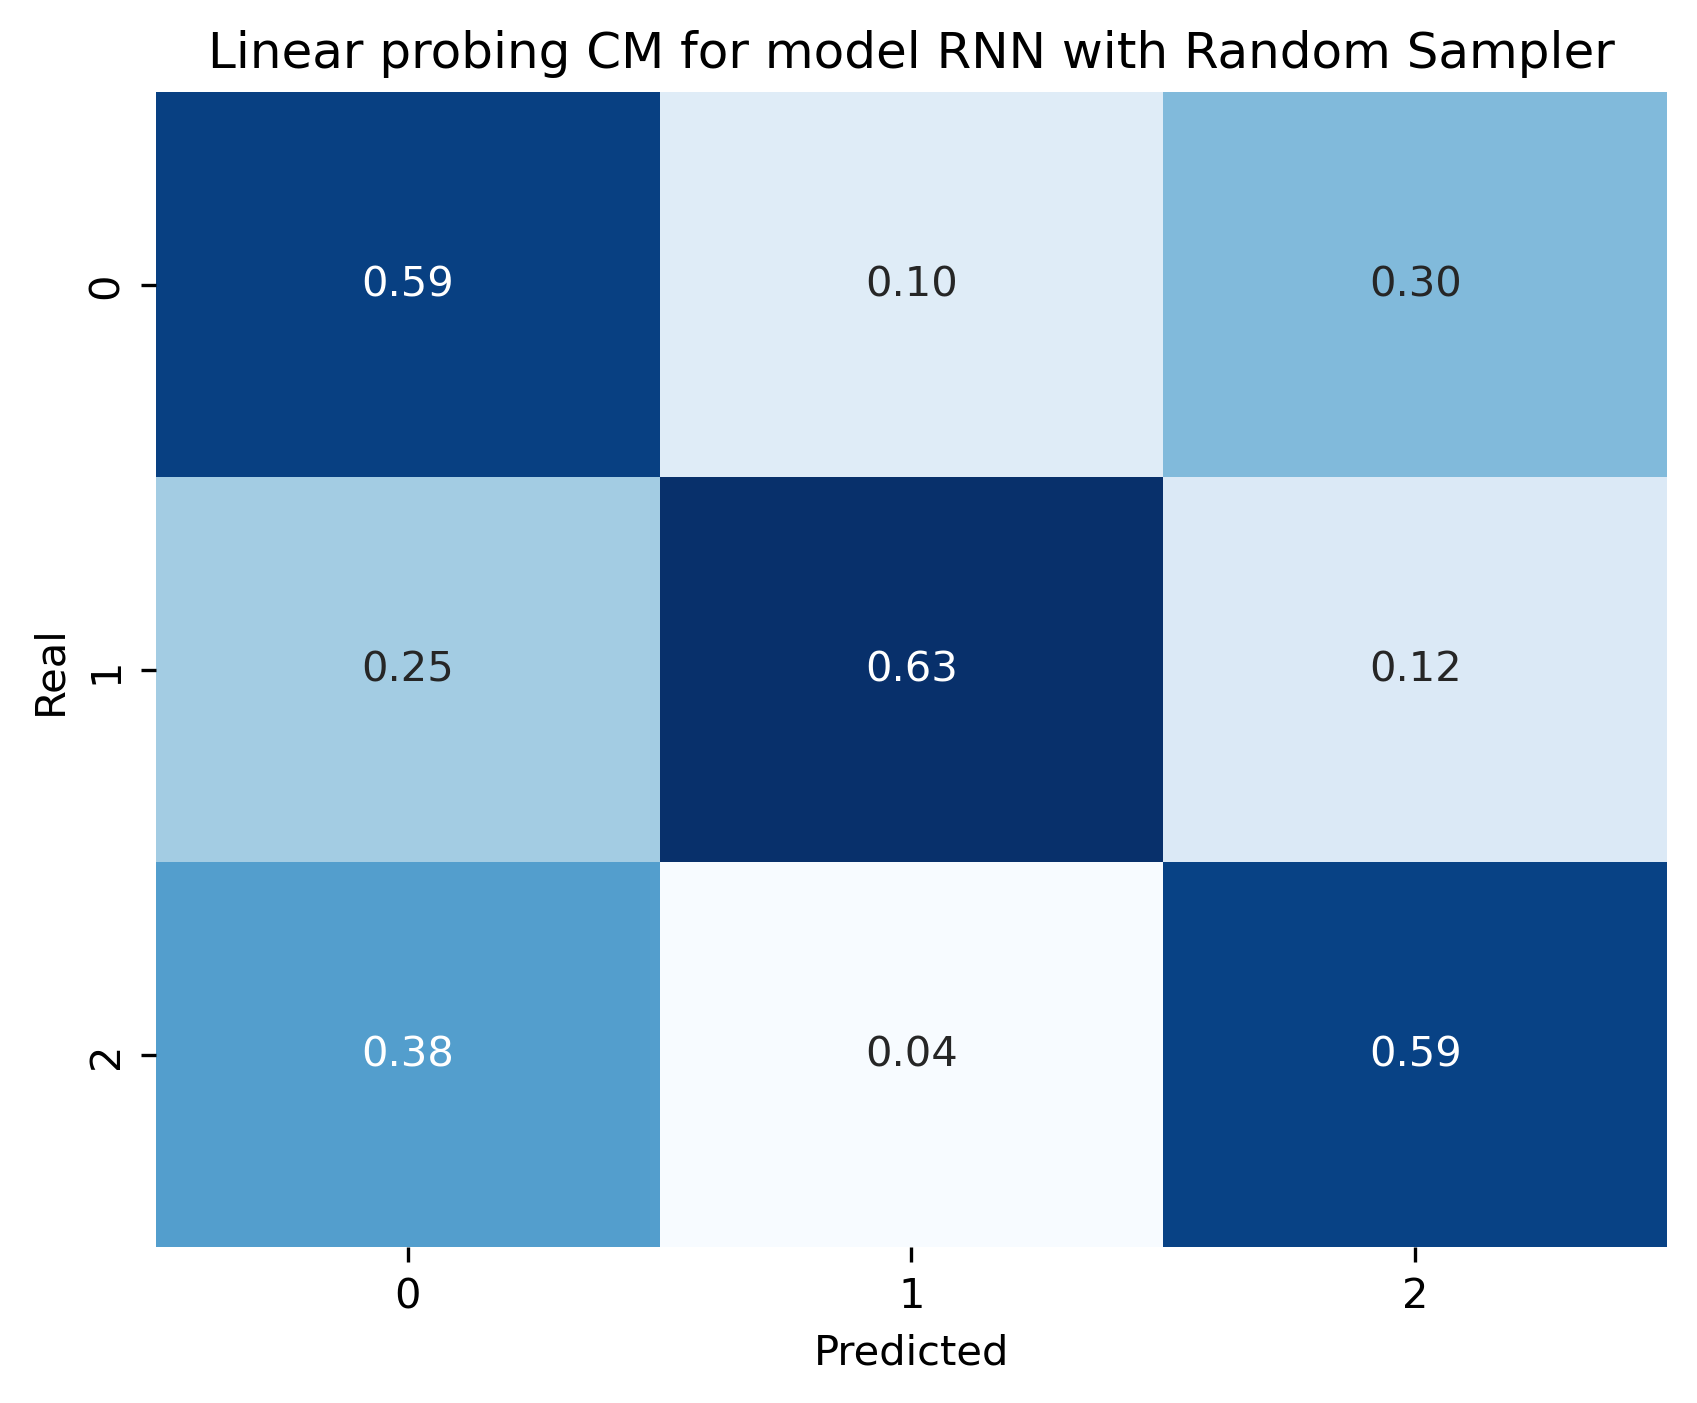

In [30]:
#Random Sampler
rnn_model_rs = rnn.RNN('RNN', 5, 50, hidden_dim, num_layers, 3, name = "RNN with Random Sampler")
rnn_model_rs.load_state_dict(torch.load('models/rnn_rs_model_final.pth'))

predicted = torch.argmax(F.softmax(rnn_model_rs(latent_test), dim=1), dim=1)

precision, recall, f1 = metrics.performance_metrics(real_class, predicted)
cm = confusion_matrix(real_class, predicted, normalize='true')

print(f"Model: Random Sampler",
      f"\nPrecision: {precision}",
      f"\nRecall: {recall}",
      f"\nF1: {f1}\n")

fig5 = metrics.plot_matrix([rnn_model_rs], [cm])
fig5.savefig('figures/cm_rs_nb.png')